## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough! Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this project, an algorithm to perform Image Captioning using KNN is implemented. This implementation is based on the paper [A Distributed Representation Based Query Expansion Approach for Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm used in the Project:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. 

- Specifications of the Project:
    1. Implementation of the algorithm and computation of the bleu score using Faiss for nearest neighbour computation for different values of k.
    1. Trying a few options in the Faiss index factory to speed the computation for a fixed k.
    1. Qualitative study: Visualization of five images, their ground truth captions and the predicted caption.

In [1]:
# !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

In [2]:
# !gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

In [3]:
# !wget http://images.cocodataset.org/zips/val2014.zip
# !unzip /content/val2014.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip /content/annotations_trainval2014.zip

In [4]:
from tqdm import tqdm
import time
import faiss
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as dset
from nltk.translate import bleu_score
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from nltk.translate.bleu_score import sentence_bleu

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = 'val2014',
                        annFile = 'annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...


Done (t=0.31s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [7]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [8]:
cap_path = 'coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [9]:
img_path = 'coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [10]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)


predict = [['a', 'cup','on','a', 'table'],['this', 'music','is', 'bad']]
real = [[['cup','placed', 'on', 'a' 'table'], ['cup','on', 'a', 'table'], ['cup', 'on', 'a', 'bench'], ['a', 'table'], ['a', 'cup']],
        [['this','music','is','bad'],['this','is','good', 'music'],['good', 'music'],['great','songs'],['singing', 'is', 'great']]]
print('accuracy:',accuracy(predict,real))

def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre), weights = (0.5,0.5,0,0))
        accuracy += score
    return accuracy/len(predict)

predict = ['a cup on a table', 'this music is bad']
real = [['cup placed on a table', 'cup on a table', 'cup on a bench', 'a table', 'a cup'],
        ['this music is bad','this is good music','good music','great songs','singing is great']]
print('accuracy_v2:',accuracy_v2(predict,real))

accuracy: 0.8593041119630842
accuracy_v2: 0.9472135954999579


## Implementation of the Algorithm

In [11]:
class kNNImageCaptioningModel():
    def __init__(self, k, index_factory = None):
        self.k = k
        self.captions_np_flat = []
        self.index_factory = index_factory

    def findSimilarity(self, image_embeddings):

        if(self.index_factory == None):
            # Create an index for Faiss
            index = faiss.IndexFlatL2(image_embeddings.shape[1])
        else:
            index = faiss.index_factory(image_embeddings.shape[1], self.index_factory)

        # Add your data to the index
        index.add(image_embeddings)
        # index = faiss.index_cpu_to_all_gpus(index)
        # check if index is on gpu
        print(index.is_trained)

        # Query vectors to find their KNN
        # Search for KNN
        distances, indices = index.search(image_embeddings, self.k + 1)

        # Exclude the self-neighbor (the element itself)
        distances = distances[:, 1:]  # Remove the first column (self-neighbor)
        indices = indices[:, 1:]      # Remove the first column (self-neighbor)

        Z = 1.25  # Normalization factor
        similarities = 1 - distances / Z

        # Printing the similarities
        # for i, query_result in enumerate(zip(similarities, indices)):
        #     similarities_i, indices_i = query_result
        #     print(f"Query {i + 1} Nearest Neighbors (excluding itself):")
        #     for j, (similarity, index) in enumerate(zip(similarities_i, indices_i)):
        #         print(f"Neighbor {j + 1}: Index {index}, Similarity {similarity:.4f}")

        return similarities, indices

        # Perform query expansion
    def queryExpansion(self, captions, similarities):
    # Initialize an empty list to store the expanded queries
        expanded_queries = []

        # This for loops finds n expanded queries
        print("Creating query")
        for num_images in tqdm(range(image_embeddings.shape[0]), total=image_embeddings.shape[0]):
            q = []

            # This for loop finds the expanded query for current query image
            for i in range(self.k):
                for j in range(5):
                    q.append(captions[num_images][j] * similarities[num_images][i])

            q = np.array(q)
            q = np.sum(q, axis=0) / (5 * self.k)
            expanded_queries.append(q)
        
        return np.array(expanded_queries)

    def findBestCaption(self, expanded_queries, caption_embeddings):
        # Create an IndexFlatIP index for the dataset
        index_flat_ip = faiss.IndexFlatIP(caption_embeddings[0].shape[1])  # Inner product of the vectors for similarity search
        index_flat_ip = faiss.index_cpu_to_all_gpus(index_flat_ip)

        # reshape caption embeddings from (n,5,d) to (n*5,d)
        caption_embeddings_flat = caption_embeddings.reshape(-1, caption_embeddings.shape[-1])

        # normalize the caption embeddings using numpy
        caption_embeddings_flat = caption_embeddings_flat / np.linalg.norm(caption_embeddings_flat, axis=1, keepdims=True)

        # Add the caption embeddings to the index
        index_flat_ip.add(caption_embeddings_flat)

        # Search for KNN using the IndexFlatIP index
        best_caption_distance, best_caption_index = index_flat_ip.search(expanded_queries, 1)

        return best_caption_index, best_caption_distance

    def computeBleuScore(self, best_caption_index, captions_np):
        num_different_predictions = 0
        self.captions_np_flat = captions_np.flatten()
        
        bleu_scores = []
        for idx in range(len(best_caption_index)):
            predicted_caption = self.captions_np_flat[best_caption_index[idx][0]]
            true_captions = captions_np[idx]
            # print(predicted_caption[0], true_captions[0])

            # Checking if predicted caption is outside the true captions set
            if predicted_caption not in true_captions:
                predicted_caption = [predicted_caption]
                true_captions = [true_captions]
                # # printing the predicted and true captions
                # print(f"Predicted caption: {predicted_caption}")
                # print(f"True captions: {true_captions}")
                # print()
                num_different_predictions += 1
                accuracy = accuracy_v2(predicted_caption, true_captions)
                bleu_scores.append(accuracy)
            else:
                bleu_scores.append(1.0)

        return bleu_scores, num_different_predictions

In [ ]:
model = kNNImageCaptioningModel(3)
similarities, indices = model.findSimilarity(image_embeddings)
expanded_queries = model.queryExpansion(caption_embeddings, similarities)
best_caption_index, best_caption_distance = model.findBestCaption(expanded_queries, caption_embeddings)
bleu_scores, num_different_predictions = model.computeBleuScore(best_caption_index, captions_np)
AvgBleuScore = np.mean(bleu_scores)

print()
print(f"Number of predictions in which the predicted caption is not a part of the 5 given true captions: {num_different_predictions}")
print(f"Average bleu score: {AvgBleuScore}")

## Evaluating the model for different vales of k

In [ ]:
numDifferentPredictions = []
AvgBleuScores = []

k = 100
model = kNNImageCaptioningModel(k)
similarities, indices = model.findSimilarity(image_embeddings)
expanded_queries = model.queryExpansion(caption_embeddings, similarities)
best_caption_index, best_caption_distance = model.findBestCaption(expanded_queries, caption_embeddings)
bleu_scores, num_different_predictions = model.computeBleuScore(best_caption_index, captions_np)
avg_bleu_score = np.mean(bleu_scores)
numDifferentPredictions.append(num_different_predictions)
AvgBleuScores.append(avg_bleu_score)

True
Creating query


100%|██████████| 40504/40504 [00:49<00:00, 812.89it/s]


In [ ]:
numDifferentPredictions = []
AvgBleuScores = []

for k_values in range(1, 15):
    model = kNNImageCaptioningModel(k_values)
    similarities_k = similarities[:, :k_values]
    expanded_queries = model.queryExpansion(caption_embeddings, similarities_k)
    best_caption_index, best_caption_distance = model.findBestCaption(expanded_queries, caption_embeddings)
    bleu_scores, num_different_predictions = model.computeBleuScore(best_caption_index, captions_np)
    avg_bleu_score = np.mean(bleu_scores)
    numDifferentPredictions.append(num_different_predictions)
    AvgBleuScores.append(avg_bleu_score)

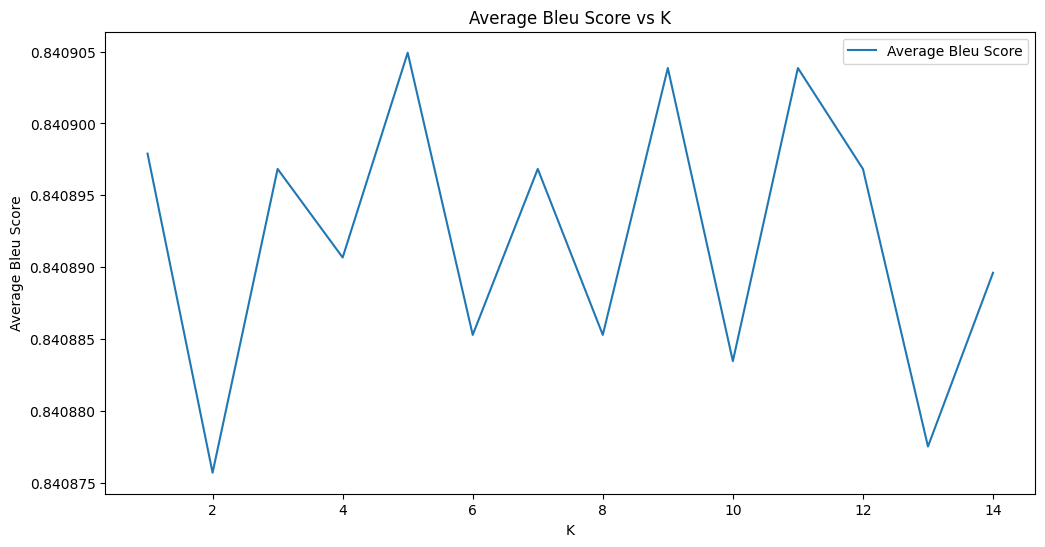

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), AvgBleuScores, label="Average Bleu Score")
plt.xlabel("K")
plt.ylabel("Average Bleu Score")
plt.title("Average Bleu Score vs K")
plt.legend()

In [ ]:
print()
print(f"Number of predictions in which the predicted caption is not a part of the 5 given true captions: {num_different_predictions}")
print(f"Average bleu score: {AvgBleuScore}")


Number of predictions in which the predicted caption is not a part of the 5 given true captions: 16406
Average bleu score: 0.8408968304949485


### Observations:
Changing the value of k (the number of neighbors considered) doesn't impact the BLEU score significantly. This suggests that the nearest neighbors for each query point (image, in this case) are quite similar regardless of how many you consider. This indicates a certain level of consistency in the given dataset where the closest neighbors tend to be very similar to each other.

## Trying a few options in the Faiss index factory to speed the computation

In [ ]:
k_IF = 3
IF_Method = ["Flat","L2norm,Flat", "HNSW32", "HNSW32,Flat"]
TimeTaken = []
AvgBleuScores = []

# find accuracy and time taken for each index
for index in IF_Method:
    print(f"Index: {index}")
    start = time.time()
    model = kNNImageCaptioningModel(k_IF, index)
    similarities, indices = model.findSimilarity(image_embeddings)
    expanded_queries = model.queryExpansion(caption_embeddings, similarities)
    best_caption_index, best_caption_distance = model.findBestCaption(expanded_queries, caption_embeddings)
    bleu_scores, num_different_predictions = model.computeBleuScore(best_caption_index, captions_np)
    avg_bleu_score = np.mean(bleu_scores)
    end = time.time()
    TimeTaken.append(end - start)
    AvgBleuScores.append(avg_bleu_score)
    print(f"Average bleu score: {avg_bleu_score}")
    print(f"Time taken: {end - start:.2f} seconds")
    print()

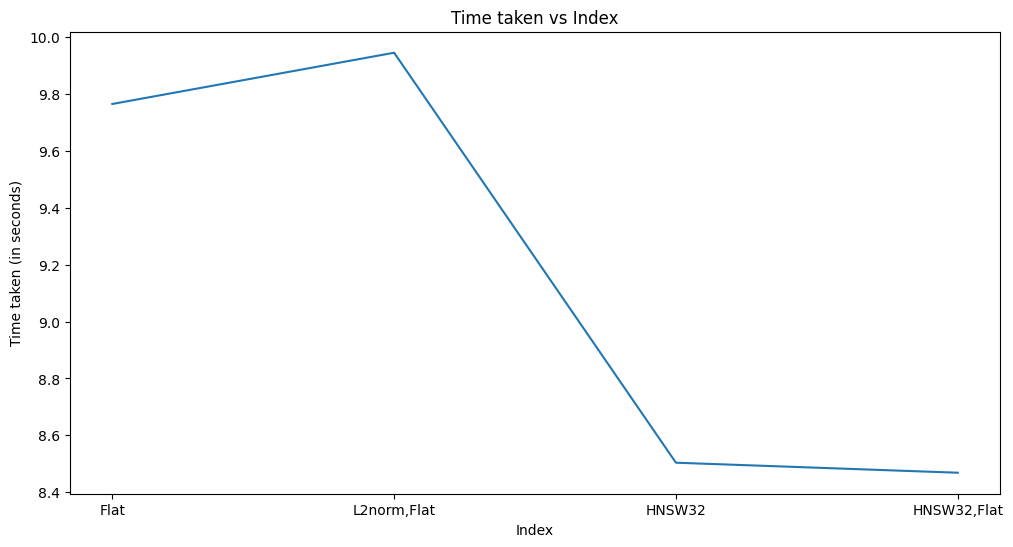

In [30]:
# Plotting the results 
plt.figure(figsize=(12, 6))
plt.plot(IF_Method, TimeTaken)
plt.xlabel("Index")
plt.ylabel("Time taken (in seconds)")
plt.title("Time taken vs Index")
plt.show()

### Observations: 
1) The fastest method for kNN computation here(k = 3), is HNSW32,Flat and the slowest method is L2norm,Flat.
2) The method used in above computation as a by default method is Flat Indexing.
3) We can conclude that by effecient indexing, the query retrieval process can be sped up.

## Qualitative study: Visualize five images, their ground truth captions and the predicted caption

Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


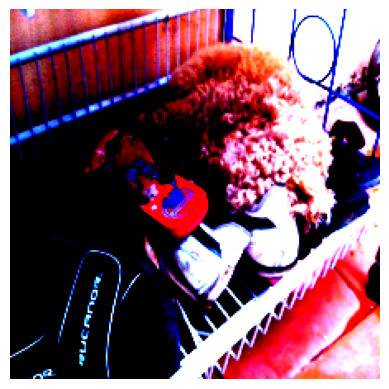

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted caption: a shoe rack with some shoes and a dog sleeping on them
True captions: ['This wire metal rack holds several pairs of shoes and sandals'
 'A dog sleeping on a show rack in the shoes.'
 'Various slides and other footwear rest in a metal basket outdoors.'
 'A small dog is curled up on top of the shoes'
 'a shoe rack with some shoes and a dog sleeping on them']

Image 2


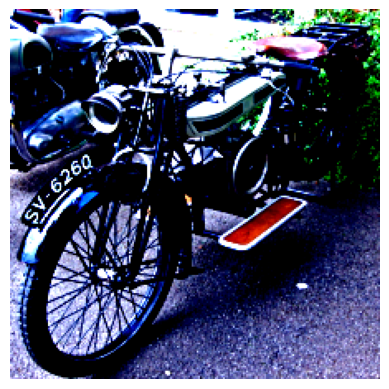

Predicted caption: A motorcycle parked in a parking space next to another motorcycle.
True captions: ['A motorcycle parked in a parking space next to another motorcycle.'
 'An old motorcycle parked beside other motorcycles with a brown leather seat.'
 'Motorcycle parked in the parking lot of asphalt.'
 'A close up view of a motorized bicycle, sitting in a rack. '
 'The back tire of an old style motorcycle is resting in a metal stand. ']

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


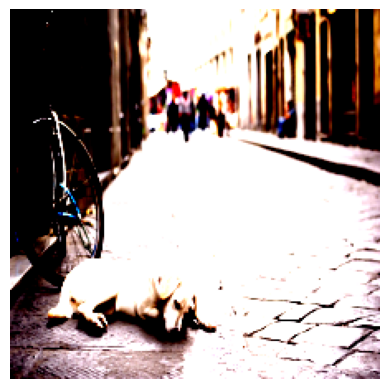

Predicted caption: a white dog is sleeping on a street and a bicycle
True captions: ['A picture of a dog laying on the ground.'
 'Dog snoozing by a bike on the edge of a cobblestone street'
 'The white dog lays next to the bicycle on the sidewalk.'
 'a white dog is sleeping on a street and a bicycle'
 'A puppy rests on the street next to a bicycle.']

Image 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


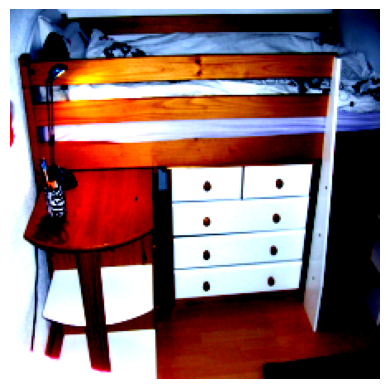

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted caption: A bed sits on top of a dresser and a desk.
True captions: ['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']

Image 5


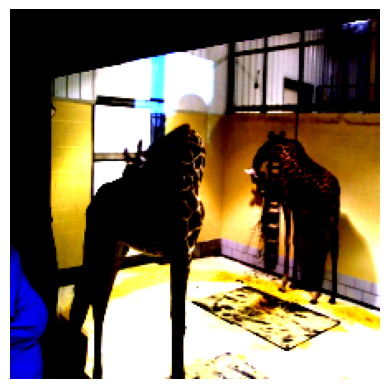

Predicted caption: Two giraffes in a room with people looking at them.
True captions: ['Two giraffes in a room with people looking at them.'
 'Two giraffe standing next to each other in a room.'
 'The giraffe is being kept by itself indoors. '
 'A man and woman staring at two giraffes through a window.'
 'a giraffe in a enclosed area is watched by some people']



In [15]:
def show_image(idx):
    img = coco_dset[idx][0]
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

captions_np_flat = captions_np.flatten()

for idx in range(5):
    predicted_caption = captions_np_flat[best_caption_index[idx][0]]
    true_captions = captions_np[idx]
    print(f"Image {idx+1}")
    show_image(idx)
    print(f"Predicted caption: {predicted_caption}")
    print(f"True captions: {true_captions}")
    print()

### Examples of cases where the predicted caption is explicitly not a subset of the true captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1


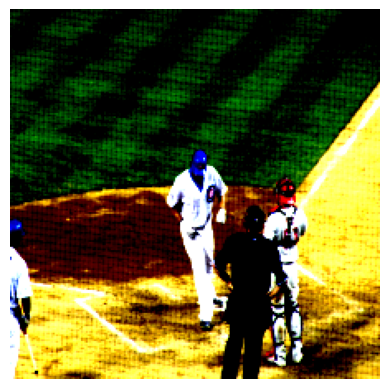

Predicted caption: ['A baseball player waiting for the pitch at home plate.']
True captions: [array(['A group of baseball players is crowded at the mound.',
       'A baseball player at the area where one goes to bat ',
       'A man that is standing in the dirt near a plate.',
       'a baseball player on the home plate during a game',
       'A baseball player for the Chicago Cubs stands at home plate.'],
      dtype='<U250')]

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


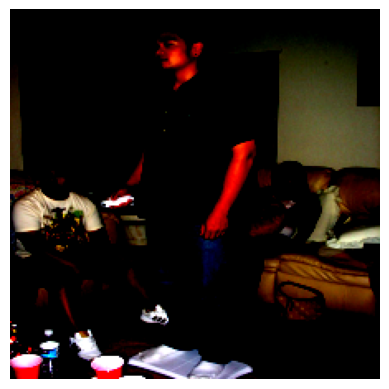

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted caption: ['A group of people playing with a video game system.']
True captions: [array(['a man standing holding a game controller and two people sitting',
       'Young adult using video game controller with other looking on.',
       'A man standing on a piece of equipment for a video game while holding the remote as four other people look on',
       'people sitting around watching a man playing a video game',
       'The group of friends is enjoyingplaying the video games.'],
      dtype='<U250')]

Image 3


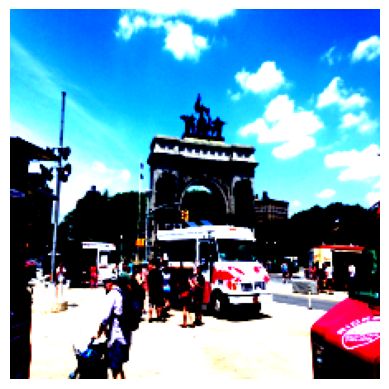

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted caption: ['A group of people getting onto a bus.']
True captions: [array(['There is a small bus with several people standing next to it.',
       'people standing besides a bus taking to each other',
       'People eating from food trucks near a commemorative archway',
       'Several people walking on a sidewalk near a large arch with figures on it.',
       'A very big pretty arch way with a bunch of people near it.'],
      dtype='<U250')]

Image 4


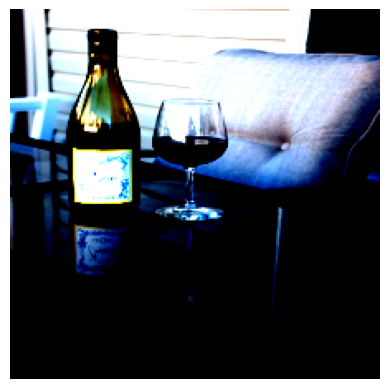

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted caption: ['A bottle of wine and a glass on a table.']
True captions: [array(['A bottle on wine next to a glass of wine.',
       'A glass table with a bottle and glass of wine next to a chair.',
       'A bottle and glass on red wine on a patio table',
       'A glass of champagne next to the champagne bottle.',
       'A glass of wine is shown wit a wine bottle right next to it on a table. '],
      dtype='<U250')]

Image 5


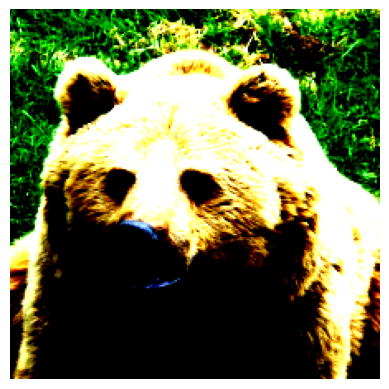

Predicted caption: ['A big brown bear outside on the grass.']
True captions: [array(['A big burly grizzly bear is show with grass in the background.',
       'The large brown bear has a black nose.',
       'Closeup of a brown bear sitting in a grassy area.',
       'A large bear that is sitting on grass. ',
       "A close up picture of a brown bear's face."], dtype='<U250')]



In [17]:
count = 0
for idx in range(15):
    predicted_caption = captions_np_flat[best_caption_index[idx][0]]
    true_captions = captions_np[idx]
    if predicted_caption not in true_captions:
        predicted_caption = [predicted_caption]
        true_captions = [true_captions]
        count += 1
        print(f"Image {count}")
        show_image(idx)
        print(f"Predicted caption: {predicted_caption}")
        print(f"True captions: {true_captions}")
        print()